# EM casing response dipole source

In [1]:
import numpy as np
import os
import scipy.sparse as sp
import pandas as pd
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import pickle
from multiprocessing import Pool

# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg import(
    maps, Report, data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils
)
from pymatsolver import Pardiso

from utils import pad_for_casing_and_data

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [3]:
directory_path = "/t40array/lheagy/casing-upscaling-inductive"

In [4]:
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

# Example usage
ensure_directory_exists(directory_path)

Directory '/t40array/lheagy/casing-upscaling-inductive' already exists.


In [5]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [6]:
# # conductivities
sigma_air = 1e-4
sigma_back = np.r_[1e-2, 3e-2, 1e-1, 3e-1, 1]
casing_l = 500
sigma_casing = 5e6
mur_casing = np.r_[1]

# # casing geometry
casing_b = 5e-2  
casing_t = 1e-2 #np.r_[5e-3, 7.5e-3, 10e-3, 12.5e-3, 15e-3, 20e-3]
casing_a = casing_b - casing_t

In [7]:
src_dz = 10
src_z = -515 #np.r_[-100, -250, -400, -495, -500, -550, -600]

In [8]:
# generate a mesh
hx = pad_for_casing_and_data(
   casing_outer_radius = casing_b,
    csx1 = casing_t/8, 
    csx2 = 25, 
    pfx1 = 1.3,
    pfx2 = 1.5, 
    domain_x = 1000, 
    npadx = 10
)

pfz = 1.3
npad_z = 28
csz = 1
n_core_extra = 10
ncore_z = int(np.max(np.r_[np.abs(casing_l), np.abs(src_z)]) / csz) + n_core_extra
hz = discretize.utils.unpack_widths(
    [(csz, npad_z, -pfz), (csz, ncore_z), (csz, npad_z, pfz)]
)

<Axes: xlabel='x', ylabel='z'>

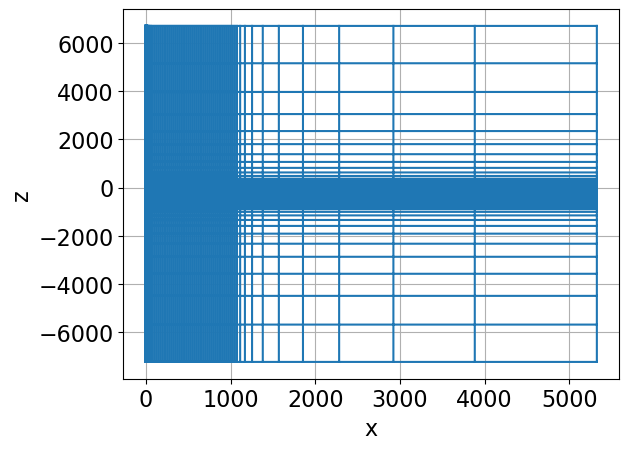

In [9]:
mesh = discretize.CylindricalMesh(
    [hx, np.r_[2*np.pi], hz], origin=np.r_[0, 0, -np.sum(hz[:npad_z + int(ncore_z)])],
)

fig, ax = plt.subplots(1, 1)
mesh.plot_grid(ax=ax)
# ax.set_xlim([0, 5])
# ax.set_ylim(-50, 10)

In [10]:
mesh.n_cells

74949

In [11]:
def get_physical_property_model(mesh, casing_a, casing_b, casing_l, sigma_back, sigma_casing, sigma_air=1e-4, mur_casing=1):

    model = np.ones(mesh.n_cells)*sigma_air
    model[mesh.cell_centers[:, 2] < 0] = sigma_back

    mur = np.ones(mesh.n_cells)

    inds_casing_x = (
        (mesh.cell_centers[:, 0] > casing_a) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -casing_l)
    )
    inds_casing = inds_casing_x & inds_casing_z

    model[inds_casing] = sigma_casing
    mur[inds_casing] = mur_casing

    return model, mur

    

In [12]:
sigma_back

array([0.01, 0.03, 0.1 , 0.3 , 1.  ])

In [13]:
models = {}
for sig in sigma_back:
    for mur in mur_casing:
        key = f"casing_sig{sig:1.0e}_mur{mur:1.0f}"
        sig_model, mur_model = get_physical_property_model(mesh, casing_a, casing_b, casing_l, sig, sigma_casing)
        models[key] = {
            "sigma": sig_model, 
            "mur": mur_model
        }
keys = list(models.keys())

In [14]:
keys

['casing_sig1e-02_mur1',
 'casing_sig3e-02_mur1',
 'casing_sig1e-01_mur1',
 'casing_sig3e-01_mur1',
 'casing_sig1e+00_mur1']

In [15]:
def plot_casing(model, xlim=None, zlim=None, vmin=None, vmax=None, ax=None, cb_label=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
    out = mesh.plot_image(
        model, pcolor_opts=pcolor_opts, ax=ax, mirror=True
    )

    cb = plt.colorbar(out[-1])
    cb.set_label(cb_label)

    if xlim is not None: 
        ax.set_xlim(xlim)
    if zlim is not None: 
        ax.set_ylim(zlim)

    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

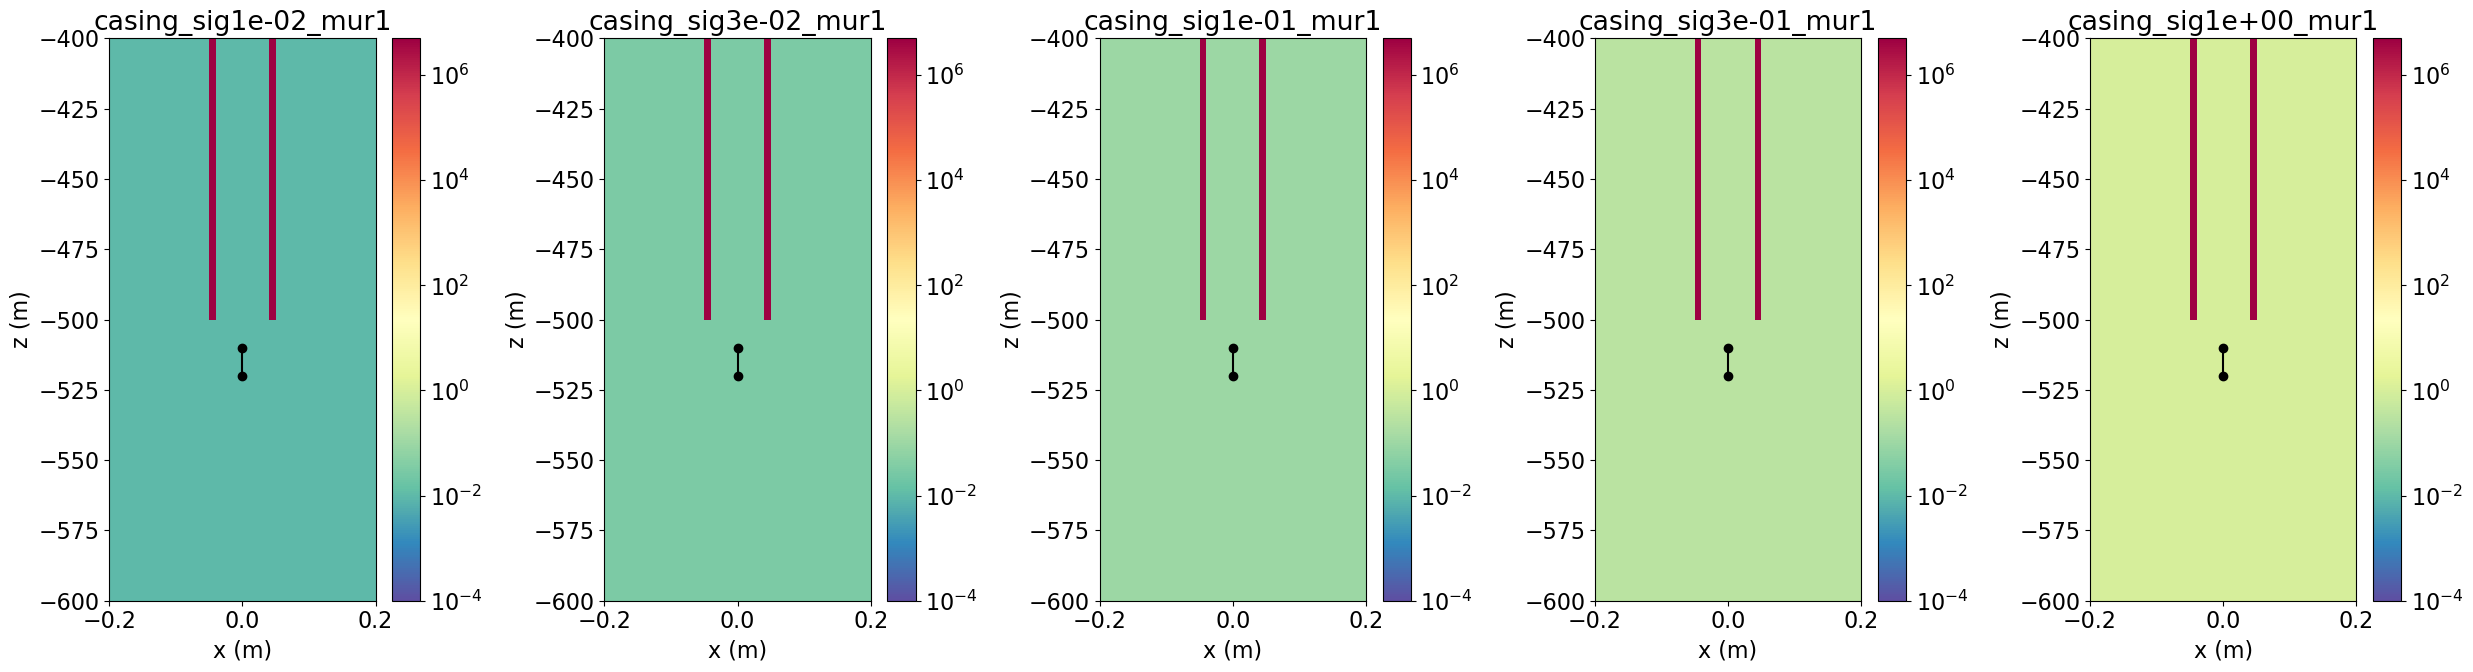

In [16]:
plot_keys = keys
fig, ax = plt.subplots(1, len(plot_keys), figsize=(5*len(plot_keys), 7))

xlim = 0.2*np.r_[-1, 1]
zlim = np.r_[-600, -400] #10]
vmin = sigma_air
vmax = sigma_casing

for i, key in enumerate(plot_keys):
    plot_casing(models[key]["sigma"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(key)
    ax[i].plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok")

plt.tight_layout()
# for loc in src_z:
#     ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

## set up the simulations

In [17]:
frequencies = 10**np.linspace(-1, 4, 36)
frequencies

array([1.00000000e-01, 1.38949549e-01, 1.93069773e-01, 2.68269580e-01,
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000000e+00,
       1.38949549e+00, 1.93069773e+00, 2.68269580e+00, 3.72759372e+00,
       5.17947468e+00, 7.19685673e+00, 1.00000000e+01, 1.38949549e+01,
       1.93069773e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02, 1.38949549e+02, 1.93069773e+02,
       2.68269580e+02, 3.72759372e+02, 5.17947468e+02, 7.19685673e+02,
       1.00000000e+03, 1.38949549e+03, 1.93069773e+03, 2.68269580e+03,
       3.72759372e+03, 5.17947468e+03, 7.19685673e+03, 1.00000000e+04])

In [18]:
src_list = []
src_location = np.r_[0, 0, src_z]
radius = 10
for f in frequencies: 
    src = fdem.sources.MagDipole([], location=src_location, frequency=f)
    # src = fdem.sources.LineCurrent([], location=src_locations, frequency=f)
    src_list.append(src)
    
survey = fdem.Survey(src_list)
sim = fdem.simulation.Simulation3DElectricField(
    mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
    survey=survey, solver=Pardiso, #mu=mur * mu_0
#     verbose=True
)

In [19]:
def run_simulation(key):
    
    filename = os.path.sep.join([directory_path, key])

    t = time.time()
    print(f"starting {key}..., saving to {filename}")
    fields = sim.fields(models[key]["sigma"])
    print(f" ... done. {time.time()-t:1.2e} \n")
    
    np.save(filename, fields[:, "eSolution"])

    return fields

In [20]:
fields = {}

In [21]:
for key in keys: 
    if key not in fields: 
        fields[key] = run_simulation(key)

starting casing_sig1e-02_mur1..., saving to /t40array/lheagy/casing-upscaling-inductive/casing_sig1e-02_mur1
 ... done. 9.58e+00 

starting casing_sig3e-02_mur1..., saving to /t40array/lheagy/casing-upscaling-inductive/casing_sig3e-02_mur1
 ... done. 8.54e+00 

starting casing_sig1e-01_mur1..., saving to /t40array/lheagy/casing-upscaling-inductive/casing_sig1e-01_mur1
 ... done. 9.39e+00 

starting casing_sig3e-01_mur1..., saving to /t40array/lheagy/casing-upscaling-inductive/casing_sig3e-01_mur1
 ... done. 8.97e+00 

starting casing_sig1e+00_mur1..., saving to /t40array/lheagy/casing-upscaling-inductive/casing_sig1e+00_mur1
 ... done. 7.94e+00 



In [22]:
fields

{'casing_sig1e-02_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DElectricField at 0x7f00e83a4bd0>,
 'casing_sig3e-02_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DElectricField at 0x7f00e79eb450>,
 'casing_sig1e-01_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DElectricField at 0x7f02c0221150>,
 'casing_sig3e-01_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DElectricField at 0x7f0103bf62d0>,
 'casing_sig1e+00_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DElectricField at 0x7f00f081d450>}

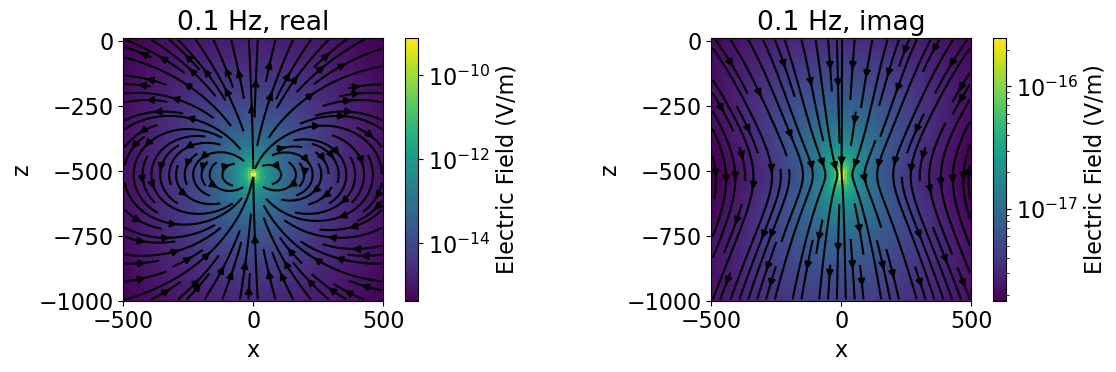

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

key = keys[1]
freq_ind = 0
xlim = 500*np.r_[-1, 1]
zlim = np.r_[-1000, 10]

field_plot = (mesh.average_face_to_cell_vector * fields[key][sim.survey.source_list[freq_ind], "b"])

for i, component in enumerate(["real", "imag"]): 
    out = mesh.plot_image(
        getattr(field_plot, component), "CCv", view="vec", 
        range_x = xlim, range_y = zlim,
        sample_grid = np.r_[10, 10],
        mirror=True, #mirror_data=field_mirror,
        ax=ax[i], 
        pcolor_opts={"norm":LogNorm()}
    )
    cb = plt.colorbar(out[0], ax=ax[i])
    cb.set_label("Electric Field (V/m)")
    ax[i].set_aspect(1)
    ax[i].set_title(f"{frequencies[freq_ind]} Hz, {component}")
plt.tight_layout()

In [24]:
# def load_fields(name, conductivity, mur):
#     solution = np.load(f"{directory}/fields_{name}.npy")
#     sim = generate_simulation(mur)
#     sim.model = conductivity
#     f = sim.fieldsPair(sim)
#     f[:, sim._solutionType] = solution
#     return f

# choose models to focus on

In [25]:
len(frequencies)

36

In [26]:
# casing_t_inv = np.r_[5e-3]
# mur_inv = np.r_[1, 50, 100, 150, 200]
# freq_inds_inv = np.arange(0, 31, 1)
# src_ind_inv = 5

# inv_keys = []
# for t in casing_t_inv:
#     for mur in mur_inv:
#         inv_keys.append(f"casing_{mur}_{t:1.2e}")
# inv_keys

In [27]:
# frequencies[freq_inds_inv]

In [28]:
# fields = {}
# for key in inv_keys:
#     # if key not in fields.keys():
#     fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])

In [29]:
rcParams["font.size"] = 13

In [30]:
fields.keys()

dict_keys(['casing_sig1e-02_mur1', 'casing_sig3e-02_mur1', 'casing_sig1e-01_mur1', 'casing_sig3e-01_mur1', 'casing_sig1e+00_mur1'])

In [31]:
def skin_depth(f, sigma, mur):
    return np.sqrt(2/(2*np.pi*f*sigma*mur*mu_0))

In [32]:
rx_x = np.linspace(25, 500, 20)
rx_z = -np.linspace(0, 600, 31) - csz/2
rx_x

array([ 25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250., 275.,
       300., 325., 350., 375., 400., 425., 450., 475., 500.])

In [33]:
def create_receivers():
    rx_bx_re = fdem.receivers.PointMagneticFluxDensity(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="real",
    )
    rx_bx_im = fdem.receivers.PointMagneticFluxDensity(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="imag",
    )
    rx_bz_re = fdem.receivers.PointMagneticFluxDensity(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="real",
    )
    rx_bz_im = fdem.receivers.PointMagneticFluxDensity(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="imag",
    )
    return rx_bx_re, rx_bx_im, rx_bz_re, rx_bz_im

In [34]:
rx_bx_re, rx_bx_im, rx_bz_re, rx_bz_im = create_receivers()
Px = rx_bx_re.getP(mesh, "Fx")
Pz = rx_bz_re.getP(mesh, "Fz")

In [58]:
Px.shape

(620, 150027)

In [59]:
fields[k][src, "b"].shape

(150027, 1)

In [36]:
# get data_vectors
dobs_dict = {}

for k in keys:
    tmp_dict = {}
    for si in range(len(frequencies)):
        src = sim.survey.source_list[si]
        b = fields[k][src, "b"]
        bxdata = (Px * b).squeeze()
        bzdata = (Pz * b).squeeze()
        tmp_dict[frequencies[si]] = {
            "real_x": bxdata.real,
            "imag_x": bxdata.imag,
            "real_z": bzdata.real,
            "imag_z": bzdata.imag,
        }
    dobs_dict[k] = tmp_dict
        

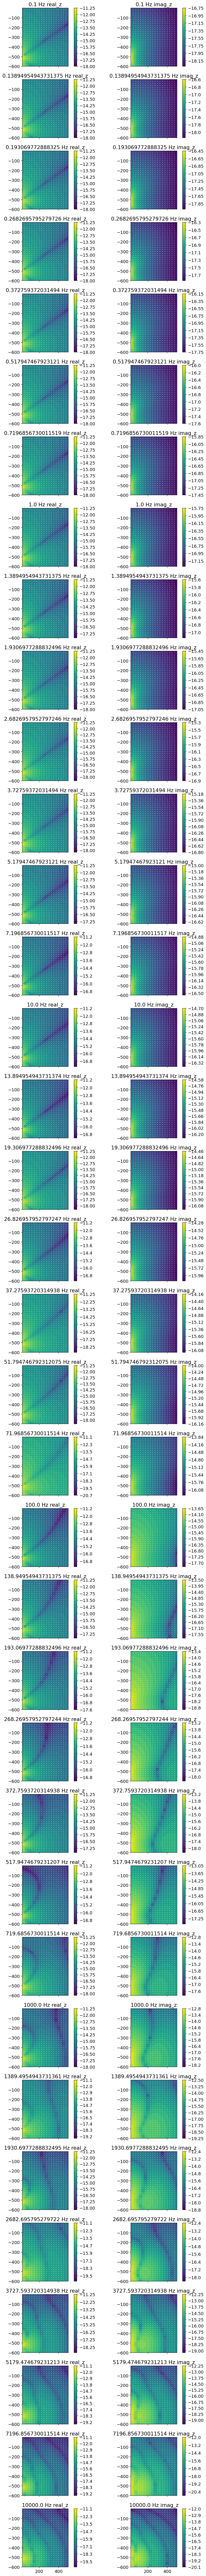

In [37]:
fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

key_ind = 0
key = keys[key_ind]

for i, freq in enumerate(frequencies): 
    # ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
    for j, component in enumerate(["real_z", "imag_z"]): 
        plt.colorbar(
            ax[i, j].contourf(
                rx_x, rx_z, np.log10(np.abs(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T)), 30,
                # vmin=-7, vmax=-2
                # norm=LogNorm()
            ), ax=ax[i, j]
        )
        
        ax[i, j].plot(rx_bx_re.locations[:, 0], rx_bx_re.locations[:, 2], "w.", ms=1)
        ax[i, j].set_aspect(1)
        ax[i, j].set_title(f"{freq} Hz {component}")

plt.tight_layout()


In [38]:
def get_amplitude_phase(real, imag):
    # real = f.real
    # imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

In [39]:
# fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

# key_ind = 0
# key = keys[key_ind]

# for i, freq in enumerate(frequencies): 
#     amp, phase = get_amplitude_phase(*(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T for component in ["real_x", "imag_x"]))
#     for j, plotme in enumerate([np.log10(np.abs(amp)), phase]): 
#         plt.colorbar(
#             ax[i, j].contourf(
#                 rx_x, rx_z, plotme, 30,
#                 # vmin=-7, vmax=-2
#                 # norm=LogNorm()
#                 cmap = "twilight" if j == 1 else "viridis"
#             ), ax=ax[i, j]
#         )
        
#         ax[i, j].plot(rx_bx_re.locations[:, 0], rx_bx_re.locations[:, 2], "w.", ms=1)
#         ax[i, j].set_aspect(1)
#         ax[i, j].set_title(f"{freq} Hz {'amplitude' if j==0 else 'phase'}")

# plt.tight_layout()


# set up mappings and simulation

In [40]:
def create_maps(key, true_inds=False, casing_t_ind=0):
    indsx = (mesh.cell_centers[:, 0] < casing_b)
    if true_inds is True: 
        indsx = indsx & (mesh.cell_centers[:, 0] > casing_b - casing_t[casing_t_ind])
    
    inds_interior = (
        indsx &
        (mesh.cell_centers[:, 2] <= 0) &
        (mesh.cell_centers[:, 2] >= -casing_l)
    )

    active_inds_sigma = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=np.log(models[key]["sigma"][~inds_interior])
    )

    active_inds_mur = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=models[key]["mur"][~inds_interior]
    )

    projection_sigma = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])
    projection_mu = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])

    exp_map = maps.ExpMap(mesh)
    mur_map = maps.MuRelative(mesh)

    sigma_map = exp_map * active_inds_sigma * projection_sigma
    mu_map = mur_map * active_inds_mur * projection_mu

    return sigma_map, mu_map

In [60]:
def create_survey(freq): 
    src_location = np.r_[0, 0, src_z]
    rx_bx_re, rx_bx_im, rx_bz_re, rx_bz_im = create_receivers()
    src = fdem.sources.MagDipole([rx_bx_re, rx_bx_im, rx_bz_re, rx_bz_im], location=src_location, frequency=freq)
    return fdem.Survey([src])

In [61]:
# create the simulation
def create_simulation(key, survey, invert_mu=False, true_inds=False):
    sigma_map, mu_map = create_maps(key, true_inds)

    if invert_mu is True: 
        wires = maps.Wires(("sigma", 1), ("mu", 1))
        sim = fdem.simulation.Simulation3DElectricField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map * wires.sigma,
            muMap=mu_map * wires.mu 
        )
    else: 
        sim = fdem.simulation.Simulation3DElectricField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map
        )
    return sim


# set up inversions

In [62]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    results_file = None
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "phi_d":[],
            "dpred":[],
            "logsigma":[],
            # "mur":[]
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["logsigma"].append(self.invProb.model[0])
        # self.inversion_results["mur"].append(self.invProb.model[0])
        
        if self.results_file is not None: 
            with open(f"{self.results_file}", "wb") as fp:
                pickle.dump(self.inversion_results, fp)
        
        

In [63]:
def create_inversion(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    maxIter=10, maxIterCG=50, maxIterLS=10, true_casing_inds=False, 
):
    # create the simulation
    survey = create_survey(freq)
    dobsvec = np.hstack(list(dobs_dict[key][freq].values()))
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu, true_casing_inds)
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    if invert_mu is True: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([2]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf, 1], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )
    else: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([1]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )

    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0)

    # directives
    target_misfit = directives.TargetMisfit(chifact=1)
    
    if true_casing_inds:
        filename_save = f"inv_{key}_{freq:1.0f}_true_casing.pkl"
    else: 
        filename_save = f"inv_{key}_{freq:1.0f}.pkl"
    inversion_progress = SaveInversionProgress(results_file=f"{directory_path}/{filename_save}")
    
    # inversion 
    inv = inversion.BaseInversion(inv_prob, [target_misfit, inversion_progress])
    
    return inv

# experiment 2: invert for solid cylinder conductivity, permeability 

In [64]:
keys

['casing_sig1e-02_mur1',
 'casing_sig3e-02_mur1',
 'casing_sig1e-01_mur1',
 'casing_sig3e-01_mur1',
 'casing_sig1e+00_mur1']

In [65]:
models.keys()

dict_keys(['casing_sig1e-02_mur1', 'casing_sig3e-02_mur1', 'casing_sig1e-01_mur1', 'casing_sig3e-01_mur1', 'casing_sig1e+00_mur1'])

In [76]:
inv_dict = {}
relative_error = 0.005
noise_floor = 1e-18

for key in keys:
    if key not in inv_dict: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = create_inversion(
                    key, freq, invert_mu=False, relative_error=relative_error, noise_floor=noise_floor,
                )
        inv_dict[key] = tmp

In [77]:
# t = casing_t
sigstart = sigma_casing * casing_t / casing_b
# starting_models = {
#     True: np.r_[np.log(sigstart), 1],
#     False: np.r_[np.log(sigstart)]
# }

In [78]:
sigstart

1000000.0

In [79]:
tmp = inv_dict[key][freq]

In [80]:
mrec_dict = {}

for key in keys:
    if key not in mrec_dict: 
        tmp = {}
        for freq in frequencies:
            print(f"\n\n------------------------ {key} : {freq} Hz -------------------------- \n")
            tmp[freq] = inv_dict[key][freq].run(np.log(sigstart)) 
            print(f"recovered conductivity: {np.exp(inv_dict[key][freq].m[0]):1.2e} \n")
        mrec_dict[key] = tmp



------------------------ casing_sig1e-02_mur1 : 0.1 Hz -------------------------- 

simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DElectricField problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  9.97e-05  0.00e+00  9.97e-05    1.02e-04      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 1.0000e+00 <= tolF*(1+|f0|) = 0.0000e+00
0 : |xc-x_last| = 1.0000e+00 <= tolX*(1+|x0|) = 0.0000e+00
1 : |proj(x-g)-x|    = 1.0218e-04 <= tolG          = 1.0000e-01
1 : |proj(x-g)-x|    = 1.021

In [81]:
inv_results = {}

for key in keys:
    if key not in inv_results: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = inv_dict[key][freq].directiveList.dList[1].inversion_results
        inv_results[key] = tmp

In [82]:
tmp = inv_results[keys[0]][frequencies[0]]

In [83]:
tmp = inv_dict[keys[0]][frequencies[0]]

In [84]:
phi_d_final = {}
chifact_final = {}
phid_star = len(rx_x)*len(rx_z)*2

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            phid_tmp[i] = phid[-1]
    phi_d_final[key] = phid_tmp
    chifact_final[key] = phi_d_final[key] / phid_star

In [85]:
phid_min = {}
chifact_min = {}
mrec_min = {}

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    mrec_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            ind_min = np.argmin(phid)
            phid_tmp[i] = phid[ind_min]
            mrec_tmp[i] = inv_results[key][freq]["logsigma"][ind_min]
    phid_min[key] = phid_tmp
    mrec_min[key] = mrec_tmp

/tmp/ipykernel_3140298/3492941605.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ax[1].loglog(frequencies, np.exp(np.hstack(mrec_dict[key].values())), "o", label=key)


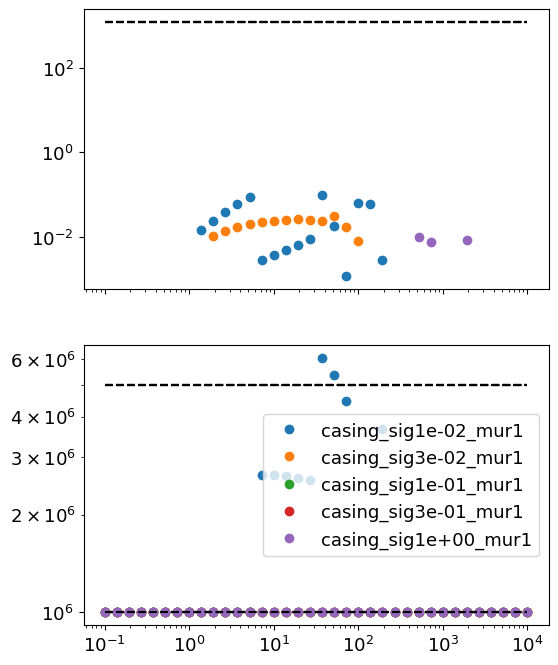

In [87]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True) 

for key in keys: 
    ax[0].loglog(frequencies, phi_d_final[key], "o", label=key)
    ax[0].semilogx(frequencies, phid_star * np.ones_like(frequencies),"--k")
    ax[1].loglog(frequencies, np.exp(np.hstack(mrec_dict[key].values())), "o", label=key)
    ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
    ax[1].loglog(frequencies, np.ones_like(frequencies)*sigstart, "--k")
ax[1].legend()

<!-- 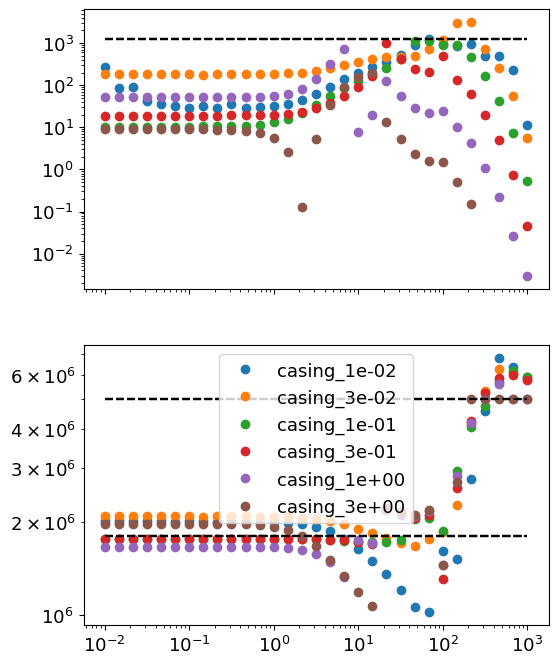 -->

In [88]:
markers = ["o", "v", "s", "^", "p", "D", "h"]

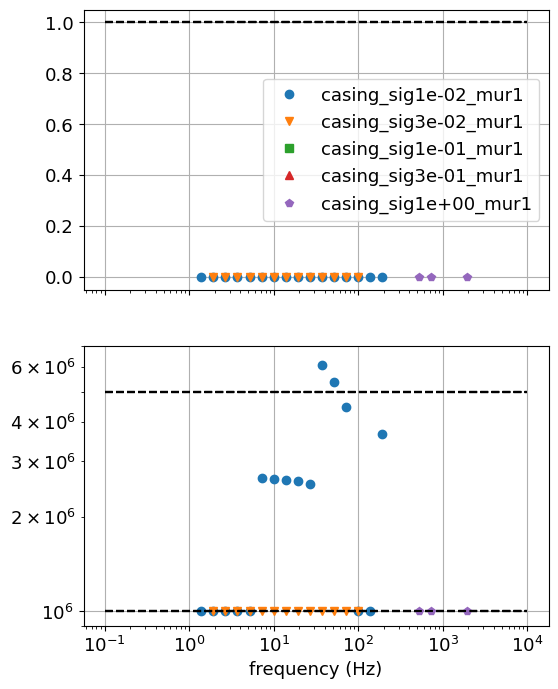

In [89]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True) 

for i, key in enumerate(keys): 
    ax[0].semilogx(frequencies, phid_min[key]/phid_star, markers[i], ms=6, label=key)
    ax[0].semilogx(frequencies, np.ones_like(frequencies),"--k")
    ax[1].loglog(frequencies, np.exp(mrec_min[key]), markers[i], ms=6, label=key)
    ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
    ax[1].loglog(frequencies, np.ones_like(frequencies)*sigstart, "--k")
ax[0].legend()

ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylim(9e5, 7e6)
for a in ax:
    a.grid()
    

<!-- 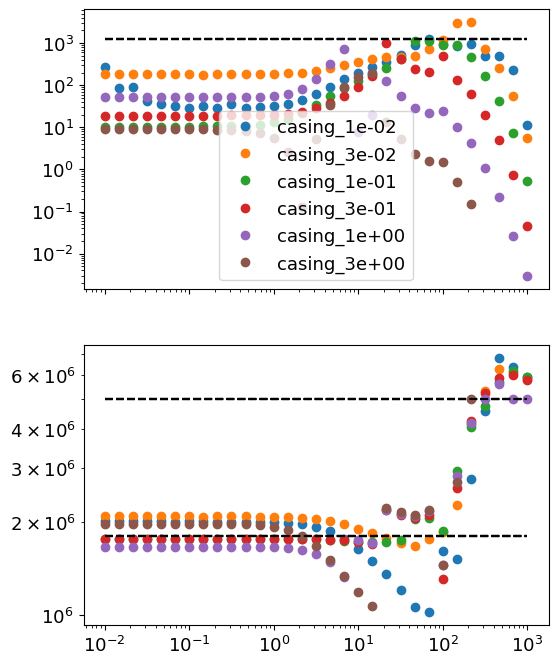 -->

In [ ]:
500/np.sqrt(sigma_casing * 2) 

In [ ]:
casing_t

In [ ]:
skin_depths_casing = 500/np.sqrt(sigma_casing * frequencies) 

fig, ax = plt.subplots(1, 1) 
ax.loglog(frequencies, skin_depths_casing)
ax.loglog(frequencies, np.ones_like(frequencies)*casing_t, "--k")
ax.loglog(frequencies, np.ones_like(frequencies)*csz, ":k")

In [ ]:
# fig, ax = plt.subplots(1,1) 

# for i, key in enumerate(mrec_dict.keys()):
#     for f, val in mrec_dict[key].items():
#         ax.loglog(
#             f, np.exp(val[False]), f"C{i}o", 
#             label=f"{key.split('-')[1]} $\mu_0$" if f==frequencies[freq_inds_inv[0]] else None
#         )
        

In [ ]:
# key = "casing_1_1.00e-02"
# freq = frequencies[freq_inds_inv[0]]

# plot_obs_pred(key, freq, False);